<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Natural Language Processing (NLP)
## *Data Science Unit 4 Sprint 1 Assignment 1*

Your goal in assignment: find the attributes of the best & worst coffee shops in the dataset. The text is fairly raw: dates in the review, extra words in the `star_rating` column, etc. You'll probably want to clean that stuff up for a better analysis. 

Analyze the corpus of text using text visualizations of token frequency. Try cleaning the data as much as possible. Try the following techniques: 
- [x] Lemmatization
- [x] Custom stopword removal

Keep in mind the attributes of good tokens. Once you have a solid baseline, layer in the star rating in your visualization(s). Keep part in this assignment - produce a write-up of the attributes of the best and worst coffee shops. Based on your analysis, what makes the best the best and the worst the worst. Use graphs and numbesr from your analysis to support your conclusions. There should be plenty of markdown cells! :coffee:

In [4]:
"""
Import Statements
"""

# Base
from collections import Counter
import re
 
import pandas as pd

# Plotting
import squarify
import matplotlib.pyplot as plt
import seaborn as sns

# NLP Libraries
import spacy
from spacy.tokenizer import Tokenizer
from nltk.stem import PorterStemmer

nlp = spacy.load("en_core_web_lg")

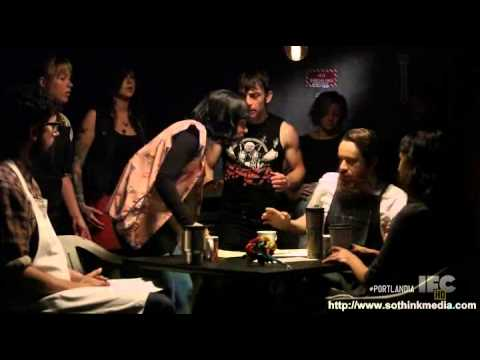

In [5]:
from IPython.display import YouTubeVideo

YouTubeVideo('Jml7NVYm8cs')

In [5]:
%pwd

'/media/main_A/Programs/regular_code/ML/NLP_w1/DS-Unit-4-Sprint-1-NLP/module1-text-data'

In [6]:
import pandas as pd

url = "https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP/master/module1-text-data/data/yelp_coffeeshop_review_data.csv"

shops = pd.read_csv(url)

In [7]:
shops.head(3)

,coffee_shop_name,full_review_text,star_rating
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0 star rating
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0 star rating
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4.0 star rating


In [8]:
# Start here 

### Cleanup!!!
# Let's make star rating integers
def clean_in(df):
    '''
    Clean star rating and trims full_review_text
    '''
    # Turn star rating into float
    df.star_rating = pd.to_numeric(df.star_rating.str.replace('star rating', ''))
    # Trim full_review_text a little
    df.full_review_text = df.full_review_text.map(lambda x: x[11:].strip())
    return df

df = clean_in(shops)

In [9]:
### Let's use lemmatization to cut everything into base chunks
### and apply this function using .apply to the whole column
def lemma(text):
    """
    Runs the sentence through the nlp object declared all the way up there.
    Then takes that and removes all the junk we don't need and puts into
    a neat new column
    """
    # declared lemmas array
    lemmas = []
    # add some stop words
    STOPPIES = nlp.Defaults.stop_words.union([
        'bean', 'Bean', 'Roast', 'roast', 'brown', 'Brown',
        'barista', 'Barista', 'smell', 'Smell', 'coffee','Coffee','it','the',
        'place', 'come', 'place', ' '])
    # Send the review text to the NLP pipeline
    outy = nlp(text)
    for token in outy:
        # Check if stop word, punctuation, or if it's a PRON which I forgot...what exactly that is
        # I think token.is_stop == False and the not in STOPPIES is redundant, true?
        if ((token.is_stop == False) and (token.text not in STOPPIES) and (token.is_punct == False)) and (token.pos_!= 'PRON'):
            lemmas.append(token.lemma_)
    return lemmas

In [10]:
# create new column, apply function
df['lemmas'] = df['full_review_text'].apply(lemma)

In [11]:
df.head()

,coffee_shop_name,full_review_text,star_rating,lemmas
0,The Factory - Cafe With a Soul,1 check-in Love love loved the atmosphere! Eve...,5.0,"[1, check, love, love, love, atmosphere, corne..."
1,The Factory - Cafe With a Soul,"Listed in Date Night: Austin, Ambiance in Aust...",4.0,"[list, Date, Night, Austin, Ambiance, Austin, ..."
2,The Factory - Cafe With a Soul,1 check-in Listed in Brunch Spots I loved the ...,4.0,"[1, check, list, Brunch, Spots, love, eclectic..."
3,The Factory - Cafe With a Soul,Very cool decor! Good drinks Nice seating How...,2.0,"[cool, decor, good, drink, nice, seating, over..."
4,The Factory - Cafe With a Soul,1 check-in They are located within the Northcr...,4.0,"[1, check, locate, Northcross, mall, shopping,..."


## How do we want to analyze these coffee shop tokens? 

- [x] Overall Word / Token Count
- [x] View Counts by Rating 
- [x] *Hint:* a 'bad' coffee shops has a rating betweeen 1 & 3 based on the distribution of ratings. A 'good' coffee shop is a 4 or 5. 

In [12]:
### All from the lecturer
# Object from Base Python
from collections import Counter

# The object `Counter` takes an iterable, but you can instaniate an empty one and update it. 
word_counts = Counter()

# Update it based on a split of each of our documents
df['lemmas'].apply(lambda x: word_counts.update(x))

word_counts.most_common(10)

[('good', 5363),
 ('great', 3881),
 ('check', 3468),
 ('like', 3378),
 ('time', 2381),
 ('drink', 2338),
 ('love', 2324),
 ('Austin', 2274),
 ('shop', 2184),
 ('order', 2150)]

In [13]:
### Instructor's Function
def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

In [14]:
wc = count(df['lemmas'])

In [15]:
wc.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
165,good,3572,5363,1.0,0.015583,0.015583,0.469013
103,great,2815,3881,2.0,0.011277,0.026859,0.369617
23,check,3175,3468,3.0,0.010077,0.036936,0.416886
162,like,2272,3378,4.0,0.009815,0.046751,0.298319
499,time,1762,2381,5.0,0.006918,0.053669,0.231355


In [16]:
wc.tail()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
17096,Strata,1,1,17098.0,0.000003,0.999988,0.000131
17097,windowed,1,1,17099.0,0.000003,0.999991,0.000131
17099,actuality,1,1,17100.0,0.000003,0.999994,0.000131
17098,crass,1,1,17101.0,0.000003,0.999997,0.000131
17100,digestion,1,1,17102.0,0.000003,1.000000,0.000131


In [17]:
df.head(1)

,coffee_shop_name,full_review_text,star_rating,lemmas
0,The Factory - Cafe With a Soul,1 check-in Love love loved the atmosphere! Eve...,5.0,"[1, check, love, love, love, atmosphere, corne..."


### View counts by rating

In [18]:
rating_words = df[['star_rating','lemmas']].copy()
bad_rw = rating_words[rating_words.star_rating < 3.0]
gud_rw = rating_words[rating_words.star_rating > 3.0]
bad_wc = count(bad_rw['lemmas'])
gud_wc = count(gud_rw['lemmas'])

In [19]:
gud_wc.head(10)

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
202,good,2929,4370,1.0,0.016266,0.016266,0.477036
103,great,2470,3418,2.0,0.012722,0.028988,0.402280
23,check,2686,2941,3.0,0.010947,0.039935,0.437459
197,like,1677,2434,4.0,0.009060,0.048995,0.273127
24,love,1584,2077,5.0,0.007731,0.056726,0.257980
45,Austin,1543,1986,6.0,0.007392,0.064118,0.251303
388,time,1343,1774,7.0,0.006603,0.070722,0.218730
0,shop,1317,1759,8.0,0.006547,0.077269,0.214495
8,drink,1272,1728,9.0,0.006432,0.083701,0.207166
63,try,1329,1707,10.0,0.006354,0.090055,0.216450


In [20]:
bad_wc.head(10)

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
30,like,294,480,1.0,0.012532,0.012532,0.398374
104,order,249,463,2.0,0.012088,0.024621,0.337398
33,good,286,403,3.0,0.010522,0.035143,0.387534
7,drink,187,352,4.0,0.009190,0.044333,0.253388
253,time,225,332,5.0,0.008668,0.053001,0.304878
21,service,203,278,6.0,0.007258,0.060260,0.275068
96,go,187,266,7.0,0.006945,0.067205,0.253388
17,get,184,251,8.0,0.006553,0.073758,0.249322
92,food,144,249,9.0,0.006501,0.080259,0.195122
475,ask,147,229,10.0,0.005979,0.086238,0.199187


In [21]:
bad_wc.count()[[0]]

word    5362
dtype: int64

In [22]:
gud_wc.count()[[0]]

word    14984
dtype: int64

In [23]:
bbng = pd.merge(gud_wc, bad_wc, left_on='word', right_on='word', how='outer', suffixes=('_good', '_bad'))
bbng.head(10)

,word,appears_in_good,count_good,rank_good,pct_total_good,cul_pct_total_good,appears_in_pct_good,appears_in_bad,count_bad,rank_bad,pct_total_bad,cul_pct_total_bad,appears_in_pct_bad
0,good,2929.0,4370.0,1.0,0.016266,0.016266,0.477036,286.0,403.0,3.0,0.010522,0.035143,0.387534
1,great,2470.0,3418.0,2.0,0.012722,0.028988,0.402280,153.0,202.0,18.0,0.005274,0.129631,0.207317
2,check,2686.0,2941.0,3.0,0.010947,0.039935,0.437459,170.0,183.0,21.0,0.004778,0.144539,0.230352
3,like,1677.0,2434.0,4.0,0.009060,0.048995,0.273127,294.0,480.0,1.0,0.012532,0.012532,0.398374
4,love,1584.0,2077.0,5.0,0.007731,0.056726,0.257980,70.0,83.0,74.0,0.002167,0.303256,0.094851
5,Austin,1543.0,1986.0,6.0,0.007392,0.064118,0.251303,111.0,137.0,33.0,0.003577,0.193206,0.150407
6,time,1343.0,1774.0,7.0,0.006603,0.070722,0.218730,225.0,332.0,5.0,0.008668,0.053001,0.304878
7,shop,1317.0,1759.0,8.0,0.006547,0.077269,0.214495,152.0,206.0,16.0,0.005378,0.119005,0.205962
8,drink,1272.0,1728.0,9.0,0.006432,0.083701,0.207166,187.0,352.0,4.0,0.009190,0.044333,0.253388
9,try,1329.0,1707.0,10.0,0.006354,0.090055,0.216450,162.0,207.0,14.0,0.005405,0.108248,0.219512


In [24]:
strange_brew = df[df['coffee_shop_name'].str.contains('Strange Brew')]

In [29]:
df.describe()

,star_rating
count,7616.000000
mean,4.169118
std,1.065311
min,1.000000
25%,4.000000
50%,4.000000
75%,5.000000
max,5.000000


In [25]:
strange_brew.groupby('coffee_shop_name').mean()

,star_rating
coffee_shop_name,
"Strange Brew, Austin Coffee",3.6


Oooof yikes, 3.6...

In [26]:
strange_brew

,coffee_shop_name,full_review_text,star_rating,lemmas
6372,"Strange Brew, Austin Coffee","1 check-in With great coffee drinks, google fi...",4.0,"[1, check, great, drink, google, fiber, intern..."
6373,"Strange Brew, Austin Coffee",I've been here twice to work. The coffee isn'...,2.0,"[twice, work, bad, plenty, parking, table, wor..."
6374,"Strange Brew, Austin Coffee","Whether you're there to study, hang out, or li...",5.0,"[study, hang, listen, live, music, cover, good..."
6375,"Strange Brew, Austin Coffee",One of the staff scolded and embarrassed this ...,1.0,"[staff, scold, embarrass, guy, sit, lounge, ch..."
6376,"Strange Brew, Austin Coffee",1 check-in Reviewing from the coffee house asp...,2.0,"[1, check, review, house, aspect, come, work, ..."
6377,"Strange Brew, Austin Coffee",check-in Check in on Yelp gets you a 10% disco...,3.0,"[check, check, Yelp, get, 10, discount, score,..."
6378,"Strange Brew, Austin Coffee",Decent coffee and easy laid back atmosphere. ...,3.0,"[decent, easy, lay, atmosphere, drop, pen, flo..."
6379,"Strange Brew, Austin Coffee","7 check-ins My friend Kendall, the cake maker,...",5.0,"[7, check, in, friend, Kendall, cake, maker, o..."
6380,"Strange Brew, Austin Coffee",This place has really expanded! Great to see a...,4.0,"[expand, great, local, establishment, great, a..."
6381,"Strange Brew, Austin Coffee",check-in Listed in Austin Coffeshop Bucket Lis...,3.0,"[check, list, Austin, Coffeshop, Bucket, List,..."


In [42]:
sb = strange_brew[['full_review_text','star_rating','lemmas']].copy()
bad_sb = sb[rating_words.star_rating < 3.0].reset_index().drop(['index'],axis=1)
gud_sb = sb[sb.star_rating > 3.0].reset_index().drop(['index'],axis=1)
bad_sb_wc = count(bad_sb['lemmas']).reset_index().drop(['index'],axis=1)
gud_sb_wc = count(gud_sb['lemmas']).reset_index().drop(['index'],axis=1)

/home/ygeun/anaconda3/envs/U4W1-NLP/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [66]:
bad_sb_wc.head(30)

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
0,work,14,24,1.0,0.016506,0.016506,0.518519
1,time,12,20,2.0,0.013755,0.030261,0.444444
2,good,10,15,3.0,0.010316,0.040578,0.370370
3,like,7,14,4.0,0.009629,0.050206,0.259259
4,room,6,12,5.0,0.008253,0.058459,0.222222
5,music,6,12,6.0,0.008253,0.066713,0.222222
6,drink,6,11,7.0,0.007565,0.074278,0.222222
7,people,8,11,8.0,0.007565,0.081843,0.296296
8,Brew,6,11,9.0,0.007565,0.089409,0.222222
9,live,3,11,10.0,0.007565,0.096974,0.111111


## Can visualize the words with the greatest difference in counts between 'good' & 'bad'?

Couple Notes: 
- Rel. freq. instead of absolute counts b/c of different numbers of reviews
- Only look at the top 5-10 words with the greatest differences


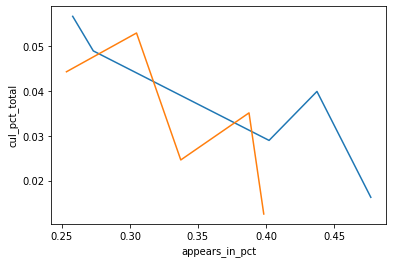

In [214]:
tf_g = gud_wc.iloc[:5]
tf_b = bad_wc.iloc[:5]
sns.lineplot(x='appears_in_pct',y='cul_pct_total',data=tf_g)
sns.lineplot(x='appears_in_pct',y='cul_pct_total',data=tf_b)

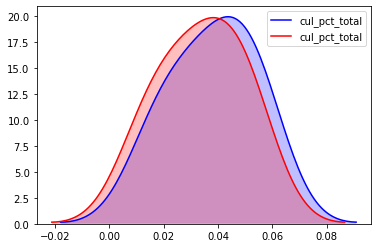

In [218]:
sns.kdeplot(tf_g['cul_pct_total'],shade=True,color='b')
sns.kdeplot(tf_b['cul_pct_total'],shade=True,color='r')

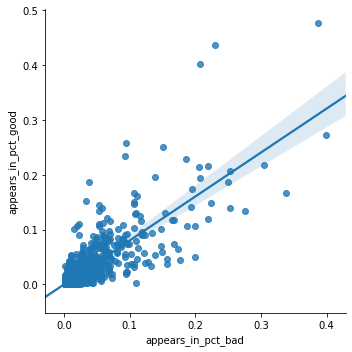

In [223]:
sns.lmplot(x='appears_in_pct_bad',y='appears_in_pct_good',data=bbng);

In [230]:
tf_g = gud_wc.iloc[:25]
tf_b = bad_wc.iloc[:25]

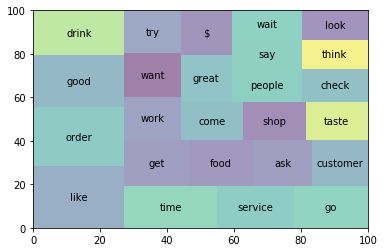

In [229]:
squarify.plot(sizes=tf_b['pct_total'], label=tf_b['word'],alpha=.5);

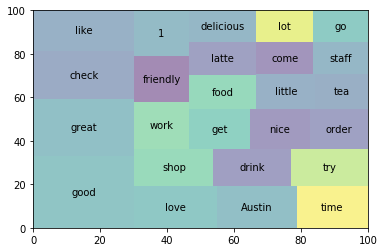

In [231]:
squarify.plot(sizes=tf_g['pct_total'], label=tf_g['word'],alpha=.5);

## Stretch Goals

* Analyze another corpus of documents - such as Indeed.com job listings ;).
* Play the the Spacy API to
 - Extract Named Entities
 - Extracting 'noun chunks'
 - Attempt Document Classification with just Spacy
 - *Note:* This [course](https://course.spacy.io/) will be of interesting in helping you with these stretch goals. 
* Try to build a plotly dash app with your text data 

